#                                      UI for RT_1 Assignment3

In [1]:
import jupyros as jr
from jupyros.ros1 import ros3d
import rospy
from ipywidgets import widgets
from ipywidgets import Button, Layout, ButtonStyle, GridBox, VBox, HBox, interact, interactive, fixed, interact_manual
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from std_srvs.srv import *
import os
import actionlib
from move_base_msgs.msg import MoveBaseAction, MoveBaseGoal
import time
import math
from sensor_msgs.msg import LaserScan
from geometry_msgs.msg import Twist, Point
from nav_msgs.msg import Odometry
from tf import transformations
from time import sleep
from __future__ import print_function
import threading
import roslib; roslib.load_manifest('teleop_twist_keyboard')
import sys, select, termios, tty

##  Buttons to define robot state.

In [2]:
rospy.init_node('Jupyter_node')
pubv = rospy.Publisher('/cmd_vel', Twist, queue_size= 1)

def key(m1):
    rospy.set_param('robot_state', 'en_keys')
    print("keys enabled")
def obsavo(m2):
    rospy.set_param('robot_state', 'en_oa')
    print("obstacle avoidance enabled")
def mb(m3):
    rospy.set_param('robot_state', 'en_mb')
    print("movebase enabled")



In [3]:
en_keys = Button(
    description = "enable_usr_keys",
    layout=Layout(width='auto', align="center", grid_area='key'),
    style = ButtonStyle(button_color = 'lightblue')
)


en_oa = Button(
    description = "enable_OA assistance",
    layout=Layout(width='auto', align="center", grid_area='obsavo'),
    style = ButtonStyle(button_color = 'pink')
) 


en_movebase = Button(
    description = "enjoy self_driving",
    layout=Layout(width='auto', align="center", grid_area='mb'),
    style = ButtonStyle(button_color = 'lightgreen')
)



In [4]:
en_keys.on_click(key)
en_oa.on_click(obsavo)
en_movebase.on_click(mb)

Box = HBox([en_keys, en_oa, en_movebase])

display(Box)

## Robot state 'en_movebase'

In [5]:
global a
global b
gr = 0
gnr = 0
def movebase(x, y):
    
    global gr
    global gnr
    global position
    twist = Twist()
    client = actionlib.SimpleActionClient('move_base',MoveBaseAction)
    position = rospy.wait_for_message("/odom", Odometry)
    goal = MoveBaseGoal()
    xr = position.pose.pose.position.x
    yr = position.pose.pose.position.y
    print('position of the robot:', xr, yr)
    goal.target_pose.header.frame_id = "map"
    goal.target_pose.header.stamp = rospy.Time.now()
    
    print("choose goal using sliders:")
    print(x)
    print(y)
    goal.target_pose.pose.position.x = x
    
    goal.target_pose.pose.position.y = y
    goal.target_pose.pose.orientation.w = 1.0
    
    client.wait_for_server()
    
    client.send_goal(goal)
    
    dist = ((x-xr)**2 + (y-yr)**2)**0.5
    if dist<0.5:
        gr += 1
    else:
        gnr += 1
    print("wait for vehicle to reach the goal")
    result = client.wait_for_result(timeout = rospy.Duration(20))

a = widgets.IntSlider(min = -20, max = 20, step = 1, value = 0, description = "x")
b = widgets.IntSlider(min = -20, max = 20, step = 1, value = 0, description = "y")
    
#def newgoal(N):
#    print ("choose new goal:")
#    movebase(x, y)
    
def cancelgoal(C):
    global gnr
    vel = Twist()
    print("goal cancelled")
    vel.linear.x = 0
    vel.angular.z = 0
    pubv.publish(vel)
    gnr += 1

CG = Button(description='Cancel Goal',
                        layout=Layout(width='auto', grid_area='C'),
                        style=ButtonStyle(button_color='salmon'))
#NG = Button(description='New Goal',
                       # layout=Layout(width='auto', grid_area='N'),
                       # style=ButtonStyle(button_color='lightgreen'))
box = HBox([CG])
display(a, b, box)

#NG.on_click(newgoal)
CG.on_click(cancelgoal)
interact(movebase, x=a, y=b); 
   

IntSlider(value=0, description='x', max=20, min=-20)

IntSlider(value=0, description='y', max=20, min=-20)

interactive(children=(IntSlider(value=0, description='x', max=20, min=-20), IntSlider(value=0, description='y'…

## Map

In [6]:
view = ros3d.Viewer()
rc = ros3d.ROSConnection(url = "ws://localhost:9090")
tf_client= ros3d.TFClient(ros = rc, fixed_frame = 'map')
laser_view = ros3d.LaserScan(topic = "/scan", ros = rc, tf_client = tf_client)
map_view = ros3d.OccupancyGrid(topic = "/map", ros = rc, tf_client = tf_client)
path = ros3d.Path(topic = "/move_base/NavfnROS/plan", ros = rc, tf_client = tf_client)
urdf = ros3d.URDFModel(ros = rc, tf_client = tf_client, path = os.environ.get('JUPYROS_ASSETS_URL', 'http://localhost:3000')) 
grid = ros3d.GridModel()
view.objects = [grid, laser_view, map_view, path, urdf]

view

Viewer(objects=[GridModel(), LaserScan(ros=ROSConnection(url='ws://localhost:9090'), tf_client=TFClient(fixed_…

## Robot State 'en_keys'

In [7]:
F = Button(description = 'Go forward',
           layout = Layout(width = 'auto', grid_area = 'F'),
           style = ButtonStyle(button_color = 'white'))
B= Button(description = 'Go backward',
          layout = Layout(width = 'auto', grid_area = 'B'),
          style = ButtonStyle(button_color = 'white'))
L= Button(description = 'Go left',
          layout = Layout(width = 'auto', grid_area = 'L'),
          style = ButtonStyle(button_color = 'white'))
R= Button(description = 'Go right',
          layout = Layout(width = 'auto', grid_area = 'R'),
          style = ButtonStyle(button_color = 'white'))
FL= Button(description = 'Go Straight left',
           layout = Layout(width = 'auto', grid_area = 'FL'),
           style = ButtonStyle(button_color = 'white'))
FR= Button(description = 'Go straight right',
           layout = Layout(width = 'auto', grid_area = 'FR'),
           style = ButtonStyle(button_color = 'white'))
BL=Button(description = 'Go Back left',
          layout = Layout(width = 'auto', grid_area = 'BL'),
          style = ButtonStyle(button_color = 'white'))
BR=Button(description = 'Go back right',
          layout = Layout(width = 'auto', grid_area = 'BR'),
          style = ButtonStyle(button_color = 'white'))
S= Button(description = 'Stop',
          layout = Layout(width = 'auto', grid_area = 'S'),
          style = ButtonStyle(button_color = 'red'))
IS = Button(description = 'Increase speed',
            layout = Layout(width = 'auto', grid_area = 'IS'),
            style = ButtonStyle(button_color = 'green'))
RS = Button(description = 'Reset speed',
            layout = Layout(width = 'auto', grid_area = 'RS'),
            style = ButtonStyle(button_color = 'yellow'))

speed = 0.5
turn = 0
def GoForward(b):
    vel = Twist()
    global speed
    vel.linear.x = 1.0*speed
    vel.angular.z = 0
    pubv.publish(vel)
    
def GoBackward(b):
    vel = Twist()
    global speed
    vel.linear.x = -1.0*speed
    vel.angular.z = 0
    pubv.publish(vel)
    
def GoLeft(b):
    vel = Twist()
    global turn
    vel.linear.x = 0
    vel.angular.z = 1.0+turn
    pubv.publish(vel)
    
def GoRight(b):
    vel = Twist()
    global turn
    vel.linear.x = 0
    vel.angular.z = -1.0*speed
    pubv.publish(vel)
    
def Gostraightleft(b):
    vel = Twist()
    global speed
    global turn
    vel.linear.x = 0.5*speed
    vel.angular.z = 1.0+turn
    pubv.publish(vel)
    
def Gostraightright(b):
    vel = Twist()
    global speed
    global turn
    vel.linear.x = 0.5*speed
    vel.angular.z = -1.0+turn
    pubv.publish(vel)
    
def Gobackleft(b):
    vel = Twist()
    global speed
    global turn
    vel.linear.x = -0.5*speed
    vel.angular.z = 1.0+turn
    pubv.publish(vel)
    
def Gobackright(b):
    vel = Twist()
    global speed
    global turn
    vel.linear.x = -0.5*speed
    vel.angular.z = -1.0+turn
    pubv.publish(vel)
    
def Increasevelocity(b):
    global speed
    global turn
    vel = Twist()
    speed = speed + 0.5
    turn = turn + 0.5
    print(speed)
    print(turn)
    print("press control buttons to enjoy high speed or increase more speed")
    pubv.publish(vel)
    
def Resetvelocity(b):
    global speed
    global turn
    speed = 0.5
    turn = 0
    vel = Twist()
    print(speed)
    print(turn)
    pubv.publish(vel)
    
    
def Stop(b):
    vel = Twist()
    speed = 0
    turn = 0
    pubv.publish(vel)
       
F.on_click(GoForward)
B.on_click(GoBackward)
L.on_click(GoLeft)
R.on_click(GoRight) 
FL.on_click(Gostraightleft)
FR.on_click(Gostraightright)
BL.on_click(Gobackleft)
BR.on_click(Gobackright)
IS.on_click(Increasevelocity)
RS.on_click(Resetvelocity)
S.on_click(Stop)

V1 = VBox([FL, L, BL])
V2 = VBox([F, S, B])
V3 = VBox([FR, R, BR])

Box1 = HBox([V1 ,V2 ,V3])

Box2 = VBox([IS, RS])

display(Box1)

display(Box2)

## Robot State 'en_oa'

In [8]:
def LaserCallback(msg):
    
    if rospy.get_param('robot_state')=='en_oa':
        vel = Twist()
        global speed
        global turn
        minR = min(min(msg.ranges[0:240]), 10)
        minf = min(min(msg.ranges[241:480]), 10)
        minl = min(min(msg.ranges[481:720]), 10)
        
        if minf<1.0:
            vel.linear.x = 0
            vel.angular.z = 1.0*speed
            
        if minf<1.0 and minR<1.0:
            vel.linear.x = 0.5*speed
            vel.angular.z = 1.0*turn 
            
        pubv.publish(vel)
        
V1 = VBox([FL, L, BL])
V2 = VBox([F, S, B])
V3 = VBox([FR, R, BR])

Box1 = HBox([V1 ,V2 ,V3])

Box2 = VBox([IS, RS])

display(Box1)
display(Box2)
sub = rospy.Subscriber('/scan', LaserScan, LaserCallback)
           

## DATA VISUALIZATION

In [9]:
%matplotlib notebook
from rosgraph_msgs.msg import Clock
from matplotlib.animation import FuncAnimation
from tf.transformations import quaternion_matrix

## Robot odometery plot

<IPython.core.display.Javascript object>


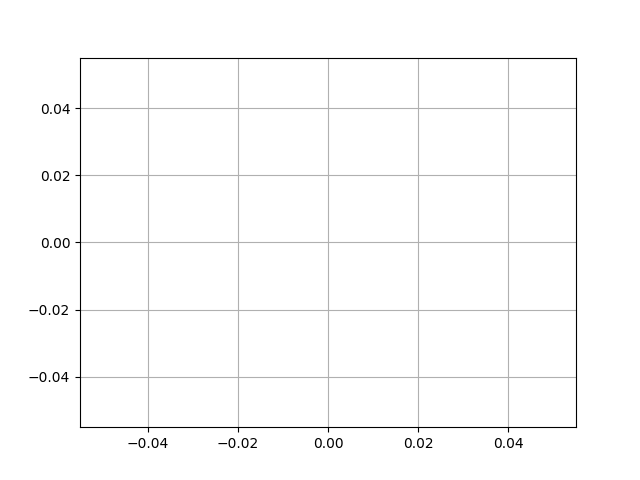

In [10]:
class odomvisualiser():
    def __init__(self):
        self.figO, self.axO = plt.subplots()
        self.lnO, = self.axO.plot([], [], 'ro')
        self.pos_x = []
        self.pos_y = []
        plt.grid(True)
    
    def plot(self):
        self.axO.set_xlim(-20,20)
        self.axO.set_ylim(-20,20)
        self.axO.set_xlabel("X",fontweight="bold")
        self.axO.set_ylabel("Y",fontweight="bold")
        
        return self.lnO
    
    def odom_pos(self, odom):
        self.pos_x.append(odom.pose.pose.position.x)
        self.pos_y.append(odom.pose.pose.position.y)
        
    def odom_callback(self, frame):
        
        self.lnO.set_data(self.pos_x, self.pos_y)
        
        legend = {'Trajectory':'purple'}
        
        labels = list(legend.keys())
        handles = [plt.Rectangle((0,0),1,1, color=legend[label]) for label in labels]
        self.axO.legend(handles, labels,loc='upper right')
        
        return self.lnO

    
vis0 = odomvisualiser() 
sub0 = rospy.Subscriber('/odom', Odometry, vis0.odom_pos)
ani0 = FuncAnimation(vis0.figO, vis0.odom_callback, init_func = vis0.plot)

plt.show(block=True)

## LaserScan plot

<IPython.core.display.Javascript object>


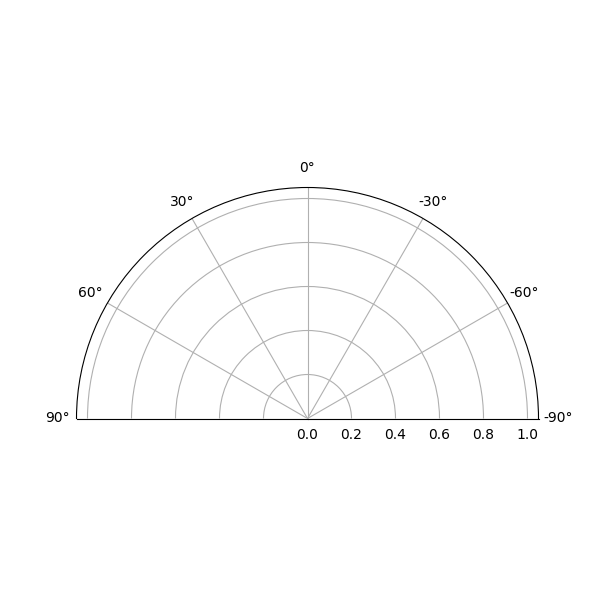

In [11]:
class laservisualiser():
    def __init__(self):
        self.FigL = plt.figure(figsize=(6,6))
        self.axL = plt.subplot(111, polar=True)
        self.axL.set_thetalim(-np.pi/2,np.pi/2)
        self.axL.set_theta_zero_location("N")
        self.lnL, = self.axL.plot([],[],'bo')
        plt.grid(True)
        
    def laser(self):
        self.axL.set_title("Laser - Distance of the Obstacles",fontweight="bold")
        self.axL.set_xlabel("Orientation [deg]",fontweight="bold")
        
        return self.lnL
    
    def ScanCallback(self, scan):
        
        global angles
        
        self.laser=list(scan.ranges)
        angles = list(np.arange(scan.angle_min, scan.angle_max+scan.angle_increment, scan.angle_increment))

        return self.laser
    
    def laser_callback(self, msg):
        global angles 
        
        legend = {'Obstacle':'orange'}
        
        labels = list(legend.keys())
        handles = [plt.Rectangle((0,0),1,1, color=legend[label]) for label in labels]
        
        self.axL.legend(handles, labels, loc ='upper right')
        self.axL.set_rmax(20)
        
        self.lnL.set_data(angles,self.laser)
        
        return self.lnL
    
    def update_laser(self, frame):
        return self.lnL
    
visL = laservisualiser()
subL = rospy.Subscriber('/scan', LaserScan, visL.ScanCallback)
aniL = FuncAnimation(visL.FigL, visL.laser_callback, init_func = visL.laser) 


plt.show(block=True)

## Pie chart for goal reached and goal not reached

In [12]:
# a pie chart to visualize the number of goals reached and not reached

class targetvisualiser():
    def __init__(self):
        self.fig1, self.ax = plt.subplots()
    
    def pie(self):
        return self.ln
    
    def pie_callback(self, msg):
        global gr
        global gnr
        sizes = [gr, gnr]
        colors = ['green', 'blue']
        patches, texts = self.ax.pie(sizes, colors = colors, startangle = 90)
        labels = ['Reached: '+ str(gr) , 'Not reached: '+ str(gnr)]
        
        self.ax.pie(sizes, colors = colors, autopct = '%1.1f%%',shadow = False, startangle = 90)
        self.ax.legend(patches, labels, loc = "best")
        
    def update_pie(self, frame):
        return self.ln
    
visP = targetvisualiser()
subP = rospy.Subscriber('/clock', Clock, visP.pie_callback)
aniP = FuncAnimation(visP.fig1, visP.update_pie, init_func = visP.pie)

plt.show(block=True)

<IPython.core.display.Javascript object>